Aljoscha Rheinwalt <aljoscha.rheinwalt@uni-potsdam.de> (2025)

# GPU block matching

+ Normalized cross correlation based block matching.
+ Variable maximum block size and search radius.
+ Optimal block size based on correlation.
+ Masked version for speed up and coarse grained view.

In [1]:
import numpy as np
from numba import cuda
from matplotlib import pyplot as pl
from matplotlib.cbook import get_sample_data
from block_matching import block_matching_ncc, block_matching_masked_ncc

Example data from Matplotlib for testing.

In [2]:
dem = get_sample_data("jacksboro_fault_dem.npz")
p = dem["elevation"]
print(p.shape)

(344, 403)


In [3]:
cuda.detect()

Found 1 CUDA devices
id 0         b'Quadro K2200'                              [SUPPORTED]
                      Compute Capability: 5.0
                           PCI Device ID: 0
                              PCI Bus ID: 3
                                    UUID: GPU-fb5f735c-79a0-4025-29dd-31b56252f155
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

Create a synthetic shift in example data for testing.

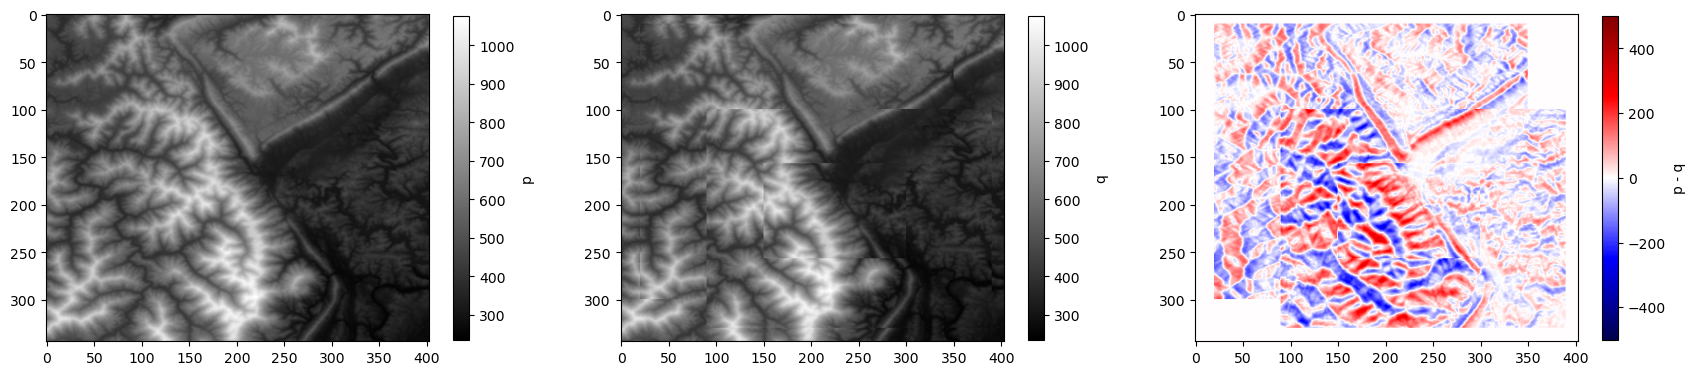

In [4]:
q = p.copy()
q[10:300, 20:350] = p[10:300, 15:345]
q[100:330, 90:390] = p[107:337, 90:390]
q[157:257, 150:300] = p[150:250, 153:303]

fg, ax = pl.subplots(1, 3, figsize=(21, 6))
im0 = ax[0].imshow(p, cmap="binary_r")
im1 = ax[1].imshow(q, cmap="binary_r")
im2 = ax[2].imshow(p - q, cmap="seismic", vmin=-500, vmax=500)
fg.colorbar(im0, ax=ax[0], shrink=0.7).set_label("p")
fg.colorbar(im1, ax=ax[1], shrink=0.7).set_label("q")
fg.colorbar(im2, ax=ax[2], shrink=0.7).set_label("p - q")
pl.show()

Synthetic shifts are within seven pixel for x and y directions so a search radius of seven pixel is sufficient.

In [5]:
block_size = 15
search_radius = 7

Now the actual GPU-based computation:

In [6]:
%%time

u, v, block_sizes, correlation = block_matching_ncc(p, q, block_size, search_radius)

CPU times: user 8.99 s, sys: 2.77 ms, total: 8.99 s
Wall time: 9 s


Visualize shifts (u, v) in (x, y) together with the optimal block size and Pearson correlation.

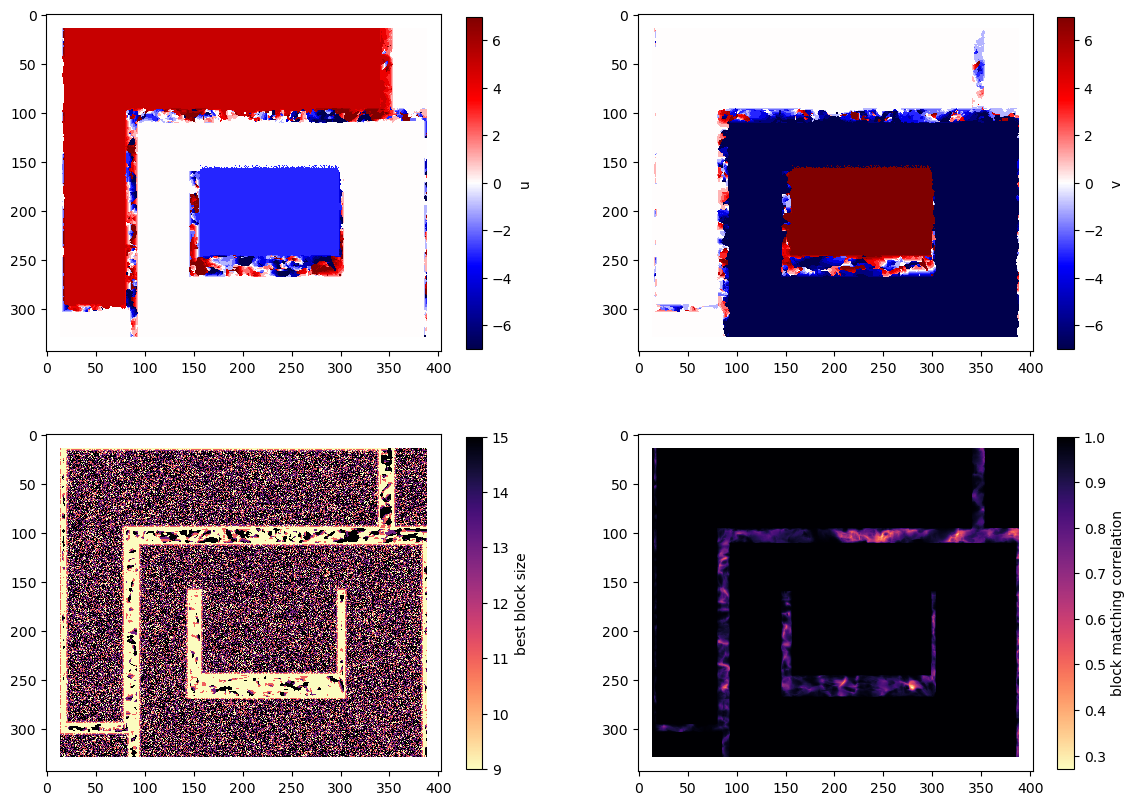

In [7]:
fg, ax = pl.subplots(2, 2, figsize=(14, 10))
ax = ax.ravel()
im0 = ax[0].imshow(u, interpolation="none", cmap="seismic")
im1 = ax[1].imshow(v, interpolation="none", cmap="seismic")
im2 = ax[2].imshow(block_sizes, interpolation="none", cmap="magma_r")
im3 = ax[3].imshow(correlation, interpolation="none", cmap="magma_r")
fg.colorbar(im0, ax=ax[0], shrink=0.95).set_label("u")
fg.colorbar(im1, ax=ax[1], shrink=0.95).set_label("v")
fg.colorbar(im2, ax=ax[2], shrink=0.95).set_label("best block size")
fg.colorbar(im3, ax=ax[3], shrink=0.95).set_label("block matching correlation")
pl.show()

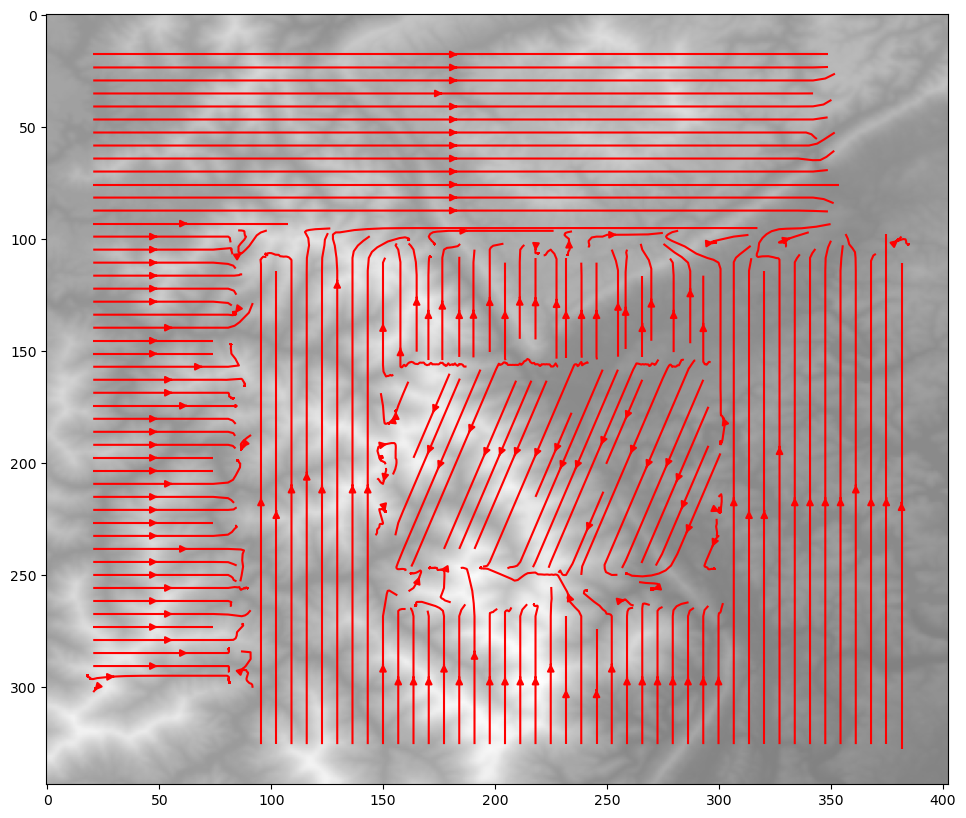

In [8]:
# streamplot
x, y = np.meshgrid(range(u.shape[1]), range(u.shape[0]))
fg, ax = pl.subplots(figsize=(15, 10))
ax.streamplot(x, y, u, v, color="r", density=2)
ax.imshow(p, cmap="binary_r", alpha=0.5)
pl.show()

In [9]:
# polar coordinates for the shift aspect angle and shift magnitude
angle = np.arctan2(v, u)
mtude = np.sqrt(u * u + v * v)

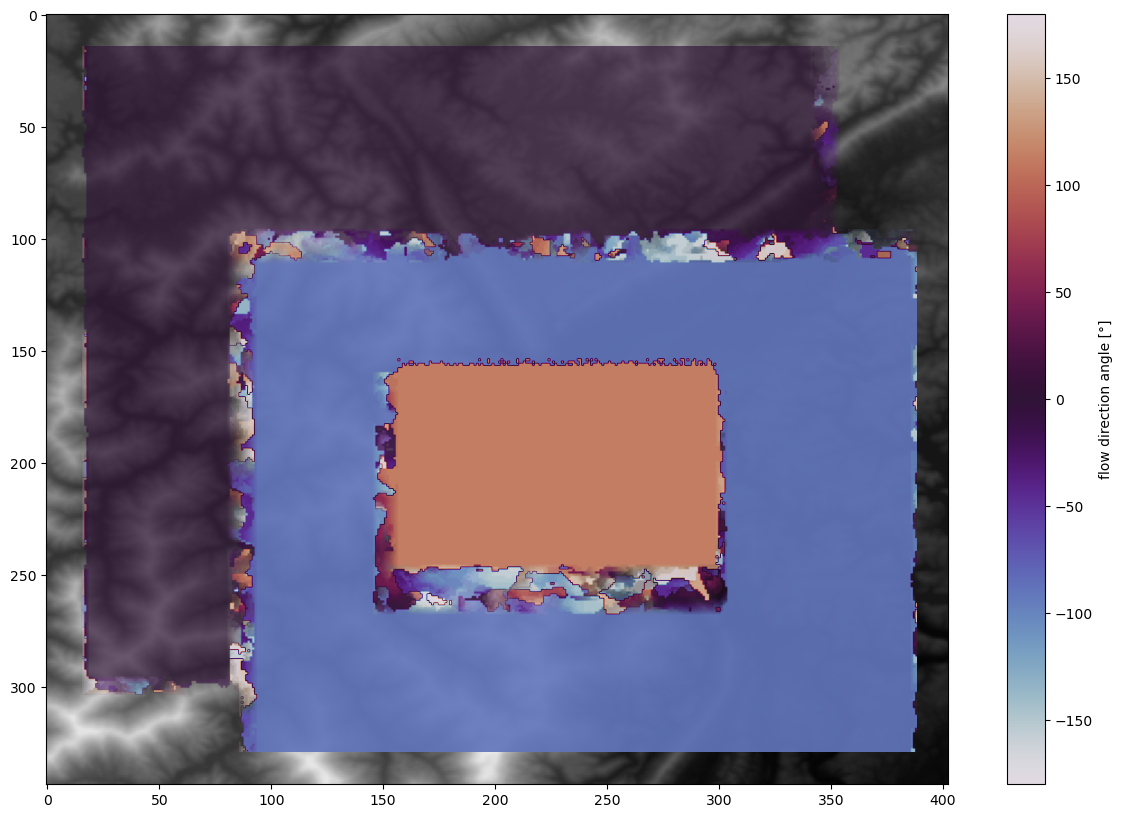

In [10]:
thr = np.nanpercentile(mtude.ravel(), 90)
alpha = mtude.copy()
alpha[np.isnan(alpha)] = 0
alpha[alpha > thr] = thr
alpha /= thr
fg, ax = pl.subplots(figsize=(15, 10))
ax.imshow(p, cmap="binary_r")
im = ax.imshow(angle * 180 / np.pi,
               vmin=-180, vmax=180,
               alpha=alpha,
               cmap="twilight")
cb = fg.colorbar(im, ax=ax)
cb.set_label("flow direction angle [°]")
pl.show()

Now doing the same using the masked version. This allows us to compute, for instance only every other pixel, or to leave out parts outside of our region of interest.

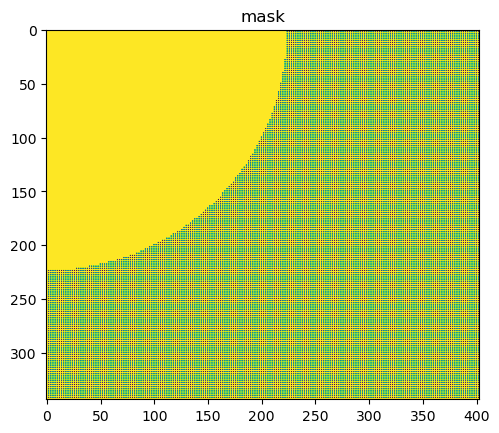

In [11]:
mask = np.ones(p.shape)
mask[::2, ::2] = 0
mask[x*x+y*y < 50000] = 1
pl.title("mask")
pl.imshow(mask)
pl.show()

Because of the lesser number of computations this is about six times faster.

In [12]:
%%time

u, v, block_sizes, correlation = block_matching_masked_ncc(p, q, mask, block_size, search_radius)

/usr/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 84 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU times: user 1.61 s, sys: 3.28 ms, total: 1.61 s
Wall time: 1.61 s


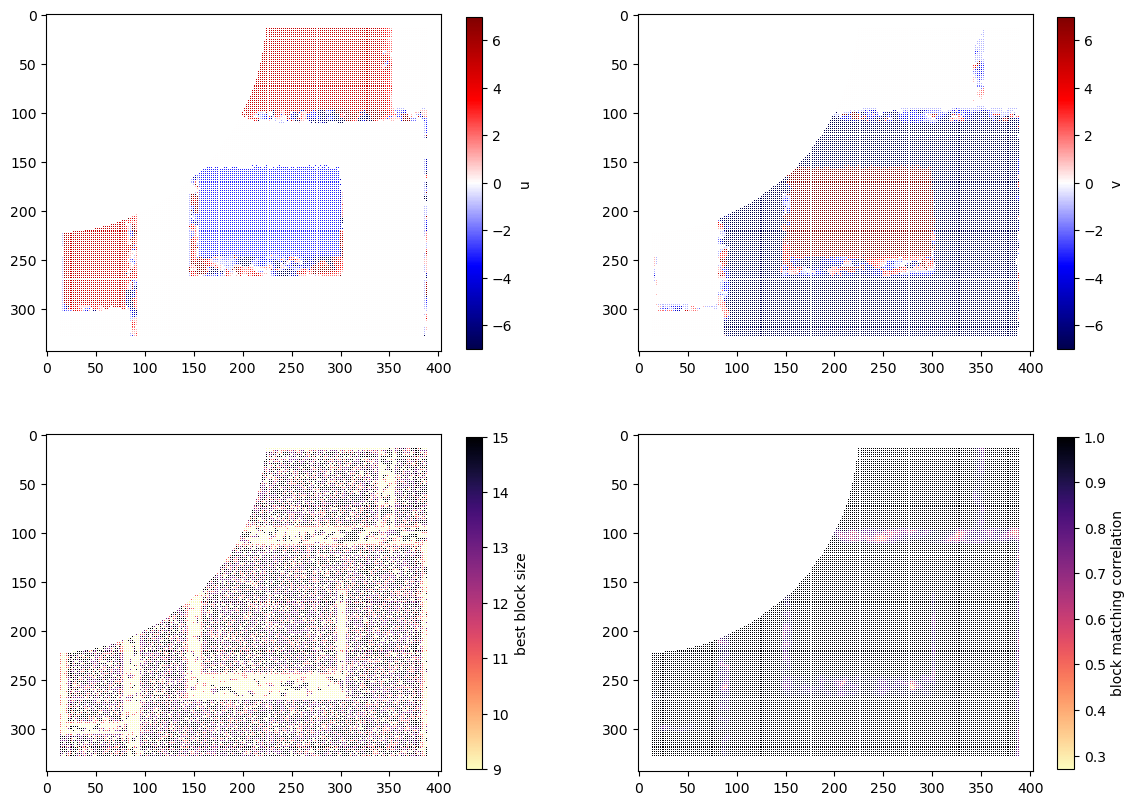

In [13]:
fg, ax = pl.subplots(2, 2, figsize=(14, 10))
ax = ax.ravel()
im0 = ax[0].imshow(u, interpolation="none", cmap="seismic")
im1 = ax[1].imshow(v, interpolation="none", cmap="seismic")
im2 = ax[2].imshow(block_sizes, interpolation="none", cmap="magma_r")
im3 = ax[3].imshow(correlation, interpolation="none", cmap="magma_r")
fg.colorbar(im0, ax=ax[0], shrink=0.95).set_label("u")
fg.colorbar(im1, ax=ax[1], shrink=0.95).set_label("v")
fg.colorbar(im2, ax=ax[2], shrink=0.95).set_label("best block size")
fg.colorbar(im3, ax=ax[3], shrink=0.95).set_label("block matching correlation")
pl.show()